<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 
    
    
____


### Full Name : Amirhossein Mahmoudi

### Student Number : 98108779

---


# Introduction


In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.


In [152]:
# Basic libraries
import numpy as np
import pandas as pd
from scipy import stats


# Statistics, EDA, metrics libraries
from scipy.stats import normaltest, skew
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox

import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
# Visualization
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt


# Data Documentation


For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data.
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "\_mut" at the end of the names of the columns)
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).


# Data Preparation (15 Points)


In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)


## Data Loading & Splitting


In [153]:
# TODO
df = pd.read_csv('METABRIC_RNA_Mutation.csv', dtype={
                 'siah1_mut': 'str', 'smarcb1_mut': 'str', 'hras_mut': 'str', 'rasgef1b_mut': 'str'})
# dfx=df.loc[:,df.columns.tolist()[678]]
# dfx.head()
# siah1_mut
# smarcb1_mut
# hras_mut
# rasgef1b_mut
df.head()


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [154]:
clinical_data = df.loc[:, "patient_id":"death_from_cancer"]
clinical_data.columns[24]


'overall_survival'

In [155]:
gene_data = df.drop(df.iloc[:, 1:31], axis=1)
gene_data['overall_survival']=df['overall_survival']
gene_data.head()


,patient_id,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut,overall_survival
0,0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,0,0,0,0,0,0,0,0,0,1
1,2,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,0,0,0,0,0,0,0,0,0,1
2,5,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,0,0,0,0,0,0,0,0,0,0
3,6,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,...,0,0,0,0,0,0,0,0,0,1
4,8,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,...,0,0,0,0,0,0,0,0,0,0


In [156]:
desired_columns = pd.Series(gene_data.columns).str.endswith(
    "_mut").apply(lambda x: not x)
gene_exp_data = gene_data.loc[:, gene_data.columns[desired_columns]]
gene_exp_data.head()


,patient_id,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,...,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,overall_survival
0,0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,...,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354,1
1,2,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,...,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920,1
2,5,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,...,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655,0
3,6,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,...,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828,1
4,8,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,...,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223,0


In [157]:
desired_columns = pd.Series(gene_data.columns).str.endswith("_mut")
# make id columns value True
desired_columns[0] = True
desired_columns[663]=True
gene_mut_data = gene_data.loc[:, gene_data.columns[desired_columns]]
gene_mut_data.head()


,patient_id,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,...,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut,overall_survival
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,H178P,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5,H1047R,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,E542K,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,8,0,S241F,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA


For each dataset, you must perform a sufficient EDA.(not mutated dataset)


#clinical data EDA


Text(0.5, 1.0, 'Missing value')

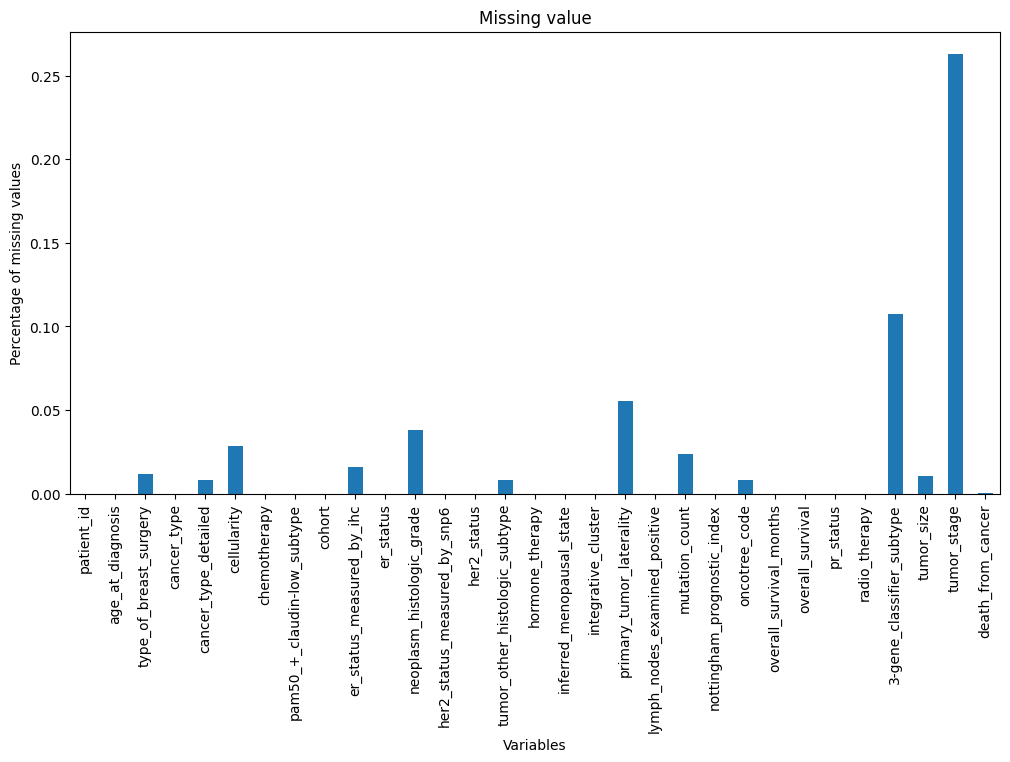

In [158]:
# Plot of missing value percentage
clinical_data.isnull().mean().plot.bar(figsize=(12, 6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Missing value')


Box plot of numerical data


In [159]:
# return numerical dataframe
def numerical_df(df):
    # drop non numerical columns
    num_df = df[df.select_dtypes(include=np.number).columns.tolist()]

    return num_df

# function that takes a dataframe and transforms it into a standard form after dropping non numirical columns


def numerical_standardizer(df):
    # drop non numerical columns
    num_df = numerical_df(df)
    # making standard scalar:removing mean and scale to variance 1
    standard_scalar = StandardScaler()
    # apply
    std = standard_scalar.fit_transform(num_df)
    # making new  dataframe
    standard_df = pd.DataFrame(std, index=num_df.index, columns=num_df.columns)
    return standard_df


std_clinical_data = numerical_standardizer(clinical_data)
std_clinical_data.head()


,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
0,-1.663366,1.122359,-0.512445,-1.338368,0.897956,0.788547,1.960788,NaN,1.757557,0.201518,1.173469,0.821330,-0.279656,0.396748
1,-1.662518,-1.379317,-0.512445,-1.338368,0.897956,0.788547,-0.490841,-0.911280,-0.011378,-0.530544,1.173469,0.821330,-1.071371,-1.193646
2,-1.661245,-0.941562,1.951430,-1.338368,-0.639479,0.788547,-0.245678,-0.911280,-0.002638,0.505525,-0.852174,-1.217538,-0.741490,0.396748
3,-1.660821,-1.033275,1.951430,-1.338368,-0.639479,0.788547,0.244648,-1.157725,0.014841,0.521686,1.173469,0.821330,-0.081727,0.396748
4,-1.659973,1.224091,1.951430,-1.338368,0.897956,0.788547,1.470462,-0.911280,1.789021,-1.097499,-0.852174,0.821330,0.907918,0.396748


Text(0, 0.5, 'Variables')

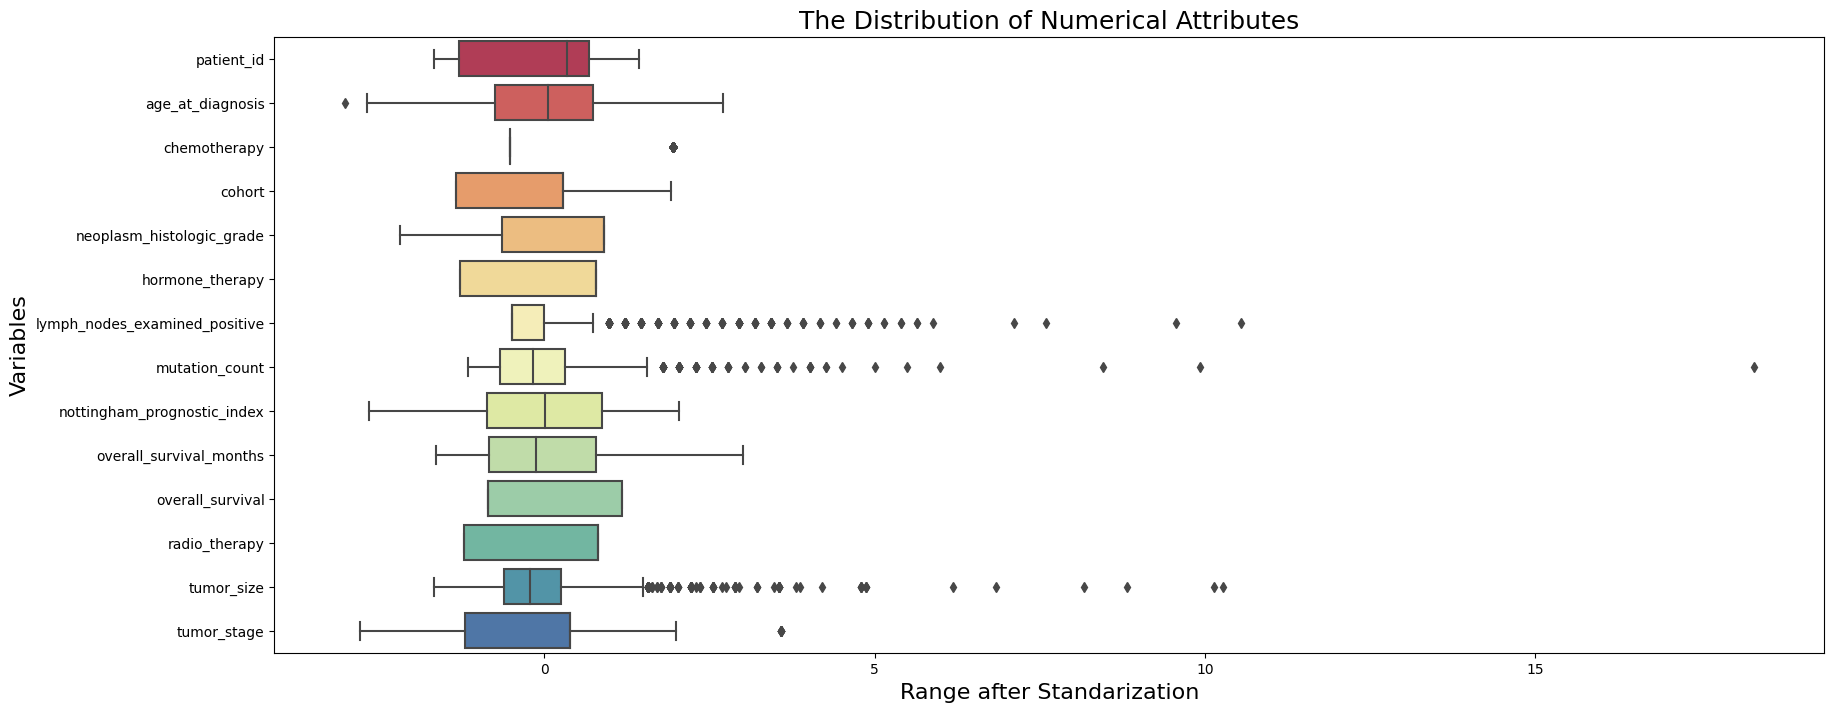

In [160]:
# Plot the boxplots of numerical variables
ax, fig = plt.subplots(1, 1, figsize=(20, 8))
plt.title('The Distribution of Numerical Attributes', fontsize=18)

sns.boxplot(y="variable", x="value", data=pd.melt(
    numerical_standardizer(clinical_data)), palette='Spectral')
plt.xlabel('Range after Standarization', size=16)
plt.ylabel('Variables', size=16)


target classes plots


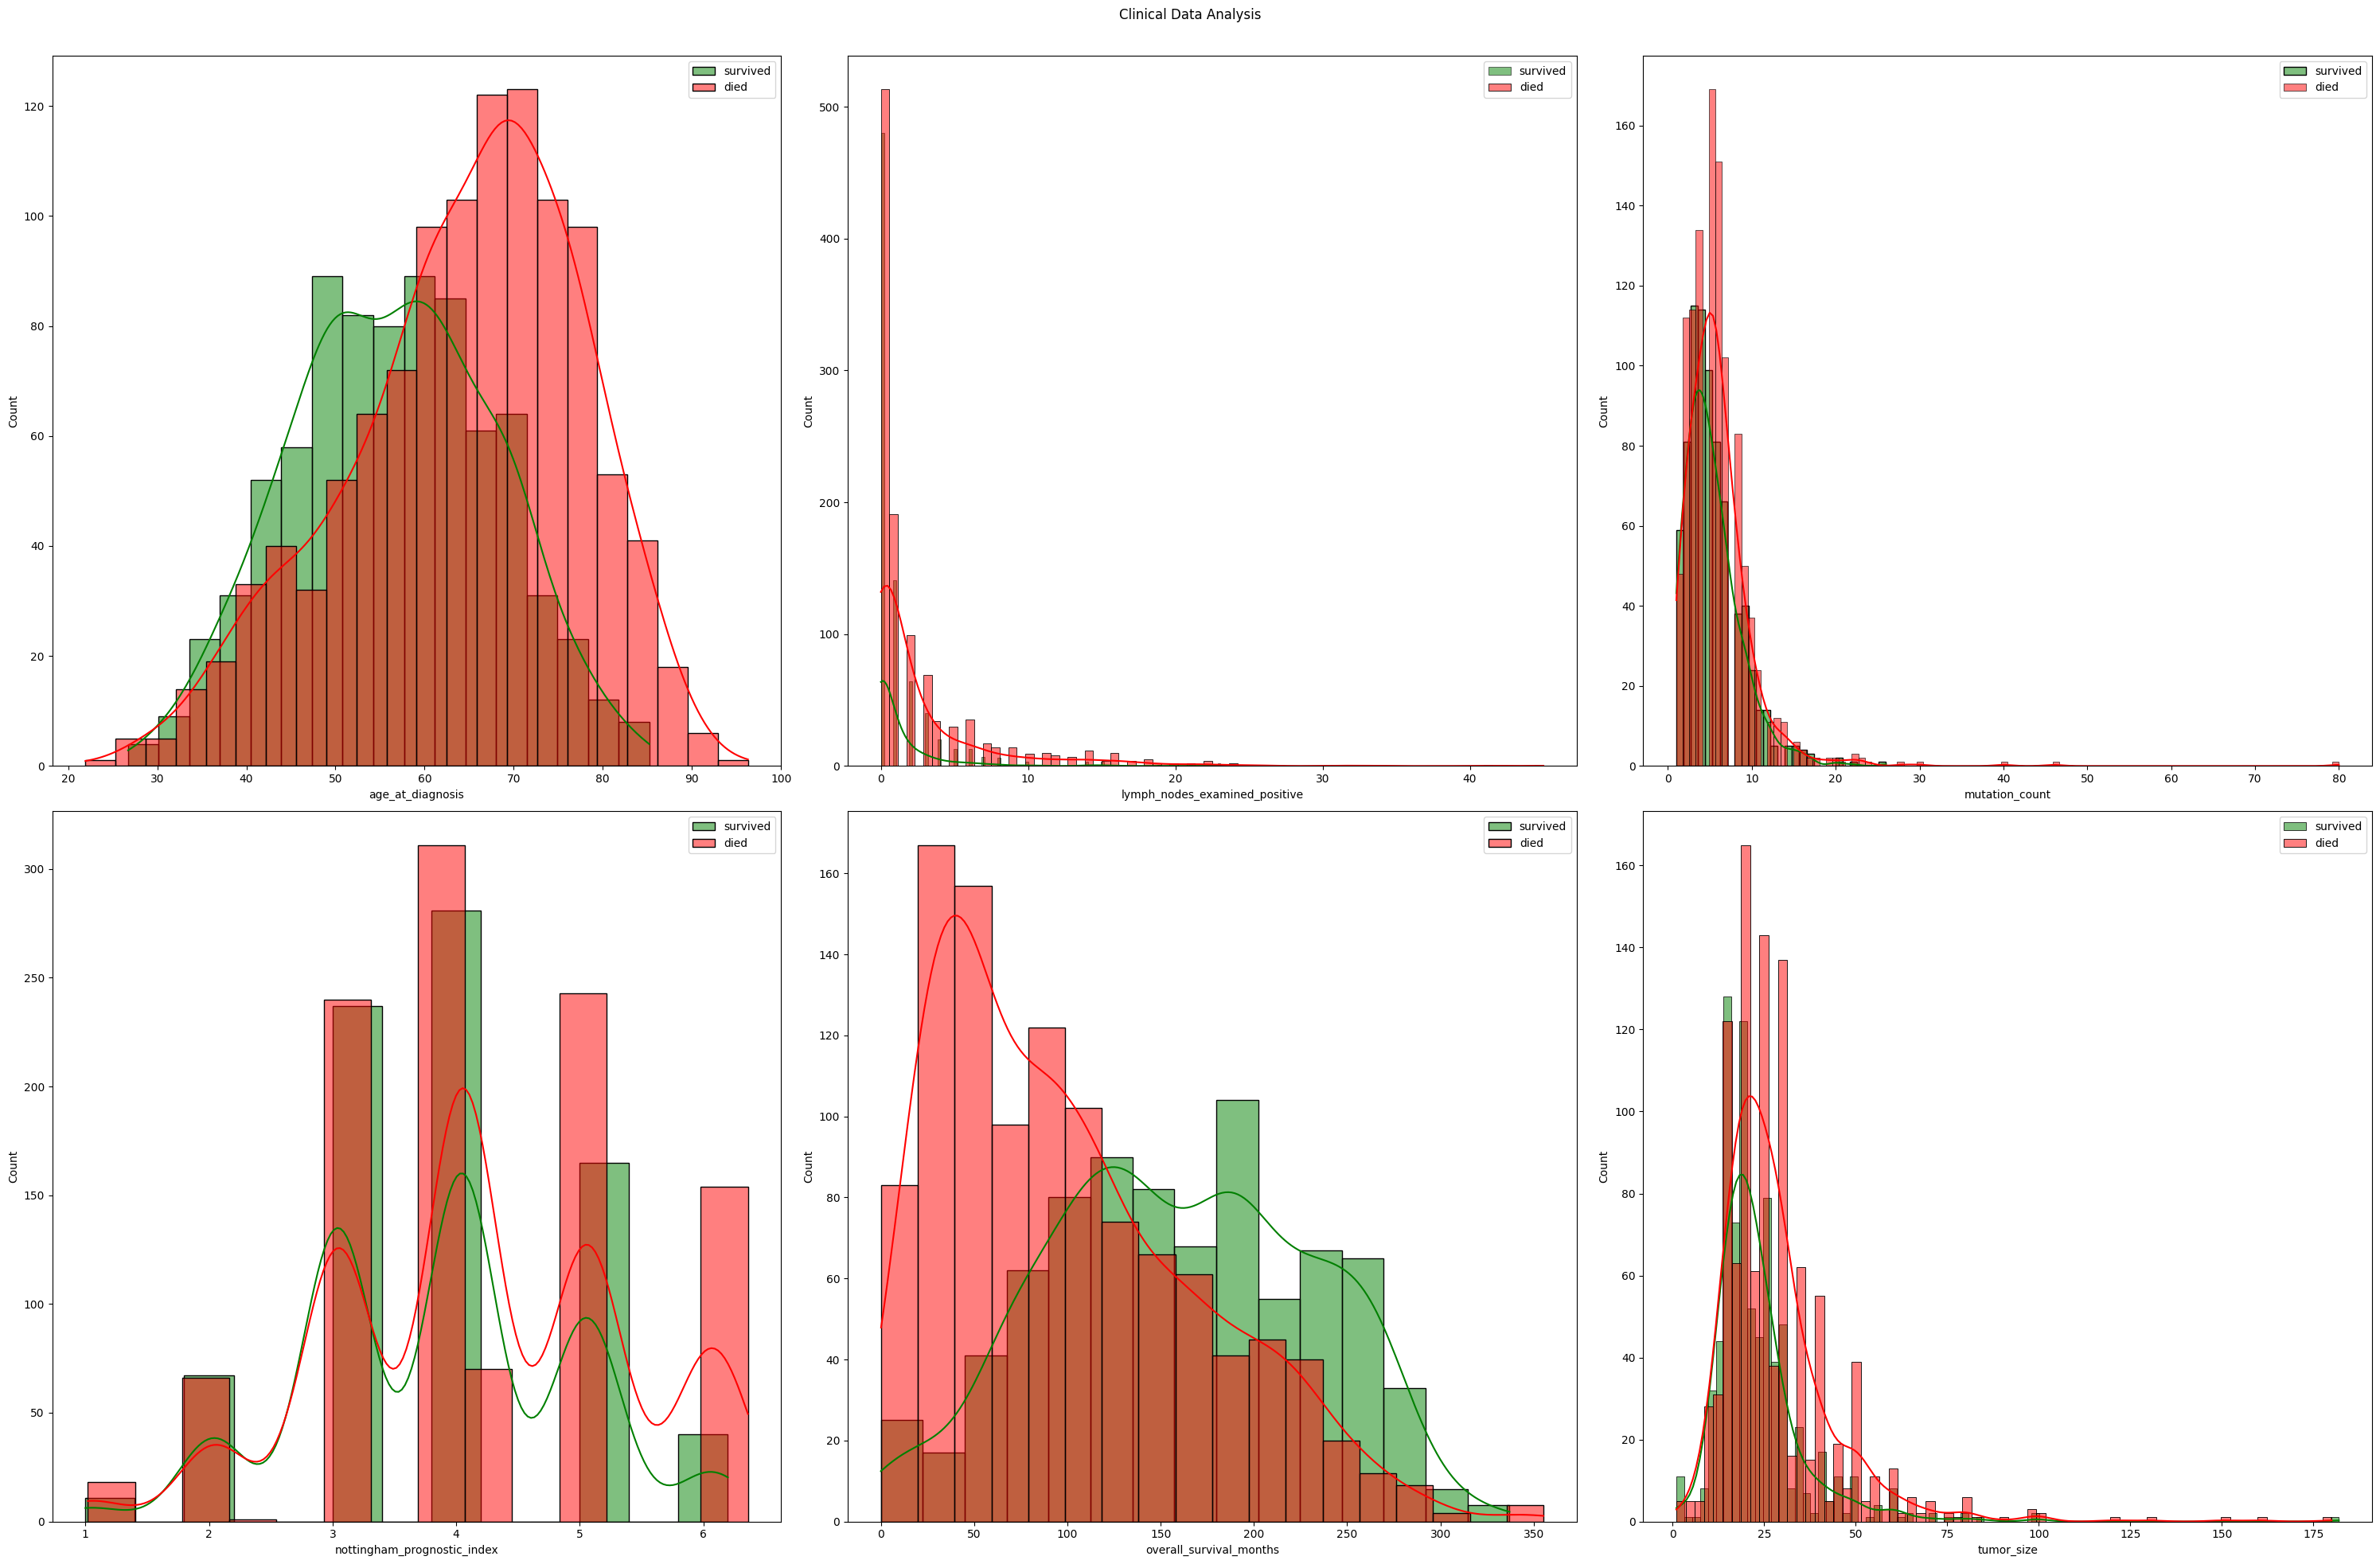

In [161]:
fig = plt.figure(figsize=(30, 20))
column_counter = 0
# num_clinical_columns= ['age_at_diagnosis', 'lymph_nodes_examined_positive','mutation_count',
#     'nottingham_prognostic_index', 'overall_survival_months', 'tumor_size' ]
important_numerical_clinical_data = numerical_df(clinical_data).drop(
    columns=['patient_id', 'chemotherapy', 'overall_survival', 'hormone_therapy', 'radio_therapy', 'neoplasm_histologic_grade', 'cohort', 'tumor_stage'])
for i in important_numerical_clinical_data:
    plt.subplot(2, 3, column_counter+1)
    column_counter += 1
    sns.histplot(clinical_data[i][clinical_data['overall_survival']
                 == 1], color='g', label='survived', kde=True)
    sns.histplot(clinical_data[i][clinical_data['overall_survival']
                 == 0], color='r', label='died', kde=True)
    plt.legend(loc='best')
fig.suptitle('Clinical Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()


Age at diagonosis:
The patients who survived have bimodal distribution
The patients who died have left skewed distribution

Lymph nodes examined positive :
both the patients who survived and died have right skewed distribution

Mutation count :
both the patients who survived and died have right skewed distribution

Nottingham prognostic index :
both the patients who survived and died have multimodal distribution

Overall survival months:
The patients who survived have bimodal distribution
The patients who died have right skewed distribution

Tumor size :
both the patients who survived and died have right skewed distribution


In [162]:
print('Baseline accuracy:' )
base_line_accuracy=df["overall_survival"].value_counts()/df["overall_survival"].count()
print(base_line_accuracy)

Baseline accuracy:
0    0.579307
1    0.420693
Name: overall_survival, dtype: float64


# Split train test Data

## making x and y for clincal data

In [163]:
categorical_columns = clinical_data.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)
categorical_columns.remove('death_from_cancer' )


dummies_df = pd.get_dummies(clinical_data.drop('patient_id',axis=1 ), columns= categorical_columns, dummy_na=True)
dummies_df.dropna(inplace = True)


clinical_X = dummies_df.drop(['death_from_cancer', 'overall_survival'], axis=1)
clinical_y = dummies_df['overall_survival']
dummies_df.head()

['type_of_breast_surgery', 'cancer_type', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'oncotree_code', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer']


,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,...,oncotree_code_MDLC,oncotree_code_nan,pr_status_Negative,pr_status_Positive,pr_status_nan,3-gene_classifier_subtype_ER+/HER2- High Prolif,3-gene_classifier_subtype_ER+/HER2- Low Prolif,3-gene_classifier_subtype_ER-/HER2-,3-gene_classifier_subtype_HER2+,3-gene_classifier_subtype_nan
1,43.19,0,1.0,3.0,1,0.0,2.0,4.020,84.633333,1,...,0,0,0,1,0,1,0,0,0,0
2,48.87,1,1.0,2.0,1,1.0,2.0,4.030,163.700000,0,...,0,0,0,1,0,0,0,0,0,1
3,47.68,1,1.0,2.0,1,3.0,1.0,4.050,164.933333,1,...,1,0,0,1,0,0,0,0,0,1
4,76.97,1,1.0,3.0,1,8.0,2.0,6.080,41.366667,0,...,1,0,0,1,0,1,0,0,0,0
5,78.77,0,1.0,3.0,1,0.0,4.0,4.062,7.800000,0,...,0,0,0,1,0,1,0,0,0,0


## split to train and test 

In [164]:
clinical_X_train, clinical_X_test, clinical_y_train, clinical_y_test = train_test_split(clinical_X, clinical_y, test_size=0.2, random_state=42, stratify = clinical_y)

## making x and y for genes data

In [165]:
gene_exp_data.dropna(inplace=True)


gen_X = gene_exp_data.drop(['patient_id', 'overall_survival'], axis=1)
gen_y = gene_exp_data['overall_survival']
gen_X.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


## split to train and test

In [166]:
gen_X_train, gen_X_test, gen_y_train, gen_y_test = train_test_split(gen_X, gen_y, test_size=0.2, random_state=42, stratify = gen_y)

## Dimension Reduction (20 + Up to 10 Points Optional)


For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.


In [167]:
# TODO
from umap import UMAP

In [168]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

## Reduction for clinical data

In [169]:
# Configure UMAP hyperparameters
reducer_clinical_3d = UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.5, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=2, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )

reducer_clinical_2d = UMAP(n_neighbors=60, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=2, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.5, # default 0.1, The effective minimum distance between embedded points.
               spread=1.5, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=2, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )

### apply reduction

In [170]:
clinical_X_train_reduced_2d=reducer_clinical_2d.fit_transform(clinical_X_train,clinical_y_train)
clinical_X_test_reduced_2d=reducer_clinical_2d.transform(clinical_X_test)
clinical_X_reduced_2d=reducer_clinical_2d.transform(clinical_X)

clinical_X_train_reduced_3d=reducer_clinical_3d.fit_transform(clinical_X_train,clinical_y_train)
clinical_X_test_reduced_3d=reducer_clinical_3d.transform(clinical_X_test)
clinical_X_reduced_3d=reducer_clinical_3d.transform(clinical_X)

### plot 2d reduction

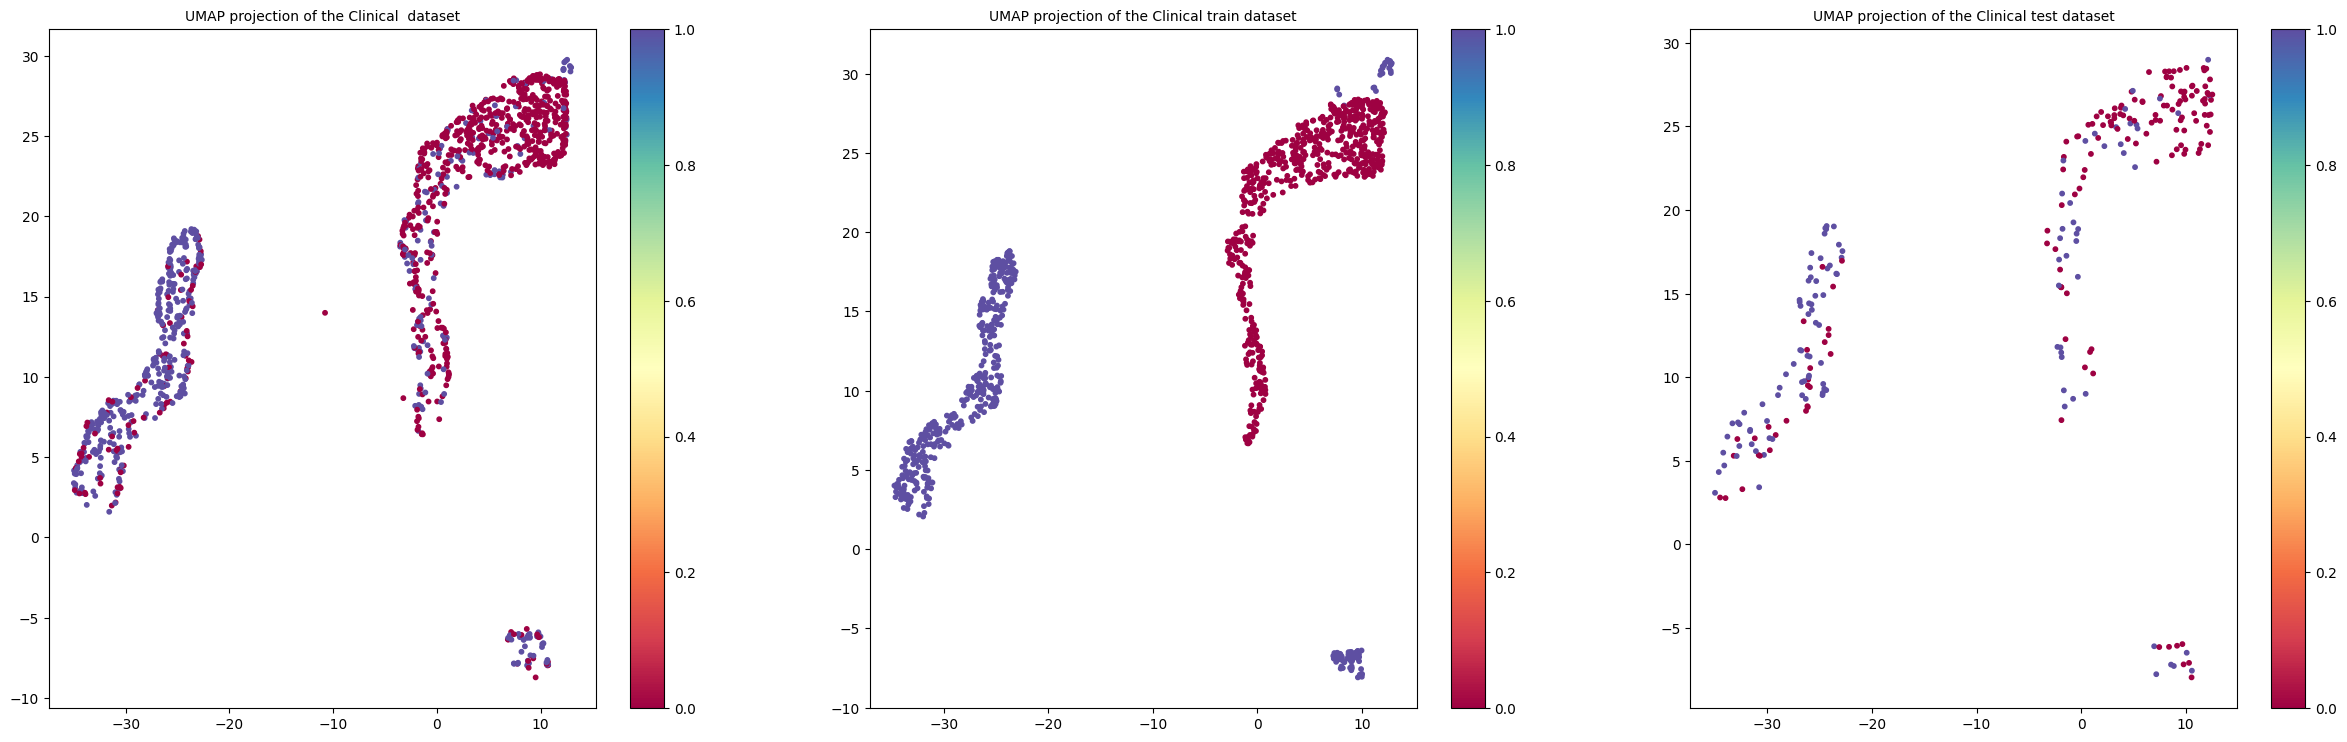

In [171]:
plt.rcParams["figure.figsize"]=(30,30)
plt.subplot(3,3,1)
plt.scatter(clinical_X_reduced_2d[:,0],clinical_X_reduced_2d[:,1], c=clinical_y, cmap='Spectral', s=10)
plt.colorbar()
plt.grid(True)
plt.title('UMAP projection of the Clinical  dataset', fontsize=10);
plt.grid()

plt.subplot(3,3,2)
plt.scatter(clinical_X_train_reduced_2d[:,0],clinical_X_train_reduced_2d[:,1], c=clinical_y_train, cmap='Spectral', s=10)
plt.colorbar()
plt.grid(True)
plt.title('UMAP projection of the Clinical train dataset', fontsize=10);
plt.grid()

plt.subplot(3,3,3)
plt.scatter(clinical_X_test_reduced_2d[:,0],clinical_X_test_reduced_2d[:,1], c=clinical_y_test, cmap='Spectral', s=10)
plt.colorbar()
plt.grid(True)
plt.title('UMAP projection of the Clinical test dataset', fontsize=10);
plt.grid()

### Plot 3d Reduction

In [172]:
chart(clinical_X_train_reduced_3d, clinical_y_train.values)
chart(clinical_X_test_reduced_3d, clinical_y_test.values)

## Reduction for genes data

In [173]:
# Configure UMAP hyperparameters
reducer_gen_3d = UMAP(n_neighbors=70, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=2, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=3, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )

reducer_gen_2d = UMAP(n_neighbors=60, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=2, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.5, # default 0.1, The effective minimum distance between embedded points.
               spread=1.5, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=2, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )

### apply reduction

In [174]:
# gen_X_train_reduced_2d=reducer_clinical_2d.fit_transform(clinical_X_train,clinical_y_train)
# clinical_X_test_reduced_2d=reducer_clinical_2d.transform(clinical_X_test)
# clinical_X_reduced_2d=reducer_clinical_2d.transform(clinical_X)

gen_X_train_reduced_3d=reducer_gen_3d.fit_transform(gen_X_train,gen_y_train)
gen_X_test_reduced_3d=reducer_gen_3d.transform(gen_X_test)
gen_X_reduced_3d=reducer_gen_3d.transform(gen_X)

### Plot 3d reduction

In [175]:
chart(gen_X_train_reduced_3d,gen_y_train.values)
chart(gen_X_test_reduced_3d,gen_y_test.values)

# Classic Model (25 Points)


In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)


## Preprocessing

In [176]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [177]:
def classic_model(model, kfold, X_train, X_test, y_train, y_test,name):
    # Scaling 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    #metrics
    results = cross_val_score(model, X_train, y_train, cv = kfold)
    print(name)
    print("CV scores: ", results); print("CV Standard Deviation: ", results.std()); print();
    print('CV Mean score: ', results.mean()); 
    print('Train score:   ', model.score(X_train, y_train))
    print('Test score:    ', model.score(X_test, y_test))
    
    
    print("\n")
    print()
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, test_pred))
    print('Classification Report:  ')
    print(classification_report(y_test, test_pred))
    train_score =  model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    return test_pred, test_score, results.mean()

## RandomForest

In [178]:
random_forest = RandomForestClassifier(random_state=42)
clinical_test_pred, clinical_test_score, clinical_cv_score = classic_model(random_forest, kfold, clinical_X_train, clinical_X_test, clinical_y_train, clinical_y_test,"Random Forest Clinical")
gen_test_pred, gen_test_score, gen_cv_score = classic_model(random_forest, kfold, gen_X_train, gen_X_test, gen_y_train, gen_y_test,"Random Forest genes")
gen_reduced_test_pred, gen_reduced_test_score, gen_reduced_cv_score = classic_model(random_forest, kfold, gen_X_train_reduced_3d, gen_X_test_reduced_3d, gen_y_train, gen_y_test,"Random Forest  reduced genes")


Random Forest Clinical
CV scores:  [0.71428571 0.70952381 0.72248804 0.76076555 0.75119617]
CV Standard Deviation:  0.020517292043702895

CV Mean score:  0.7316518569150148
Train score:    1.0
Test score:     0.7862595419847328



Confusion Matrix: 
[[125  24]
 [ 32  81]]
Classification Report:  
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       149
           1       0.77      0.72      0.74       113

    accuracy                           0.79       262
   macro avg       0.78      0.78      0.78       262
weighted avg       0.79      0.79      0.79       262

Random Forest genes
CV scores:  [0.63934426 0.66229508 0.64590164 0.63157895 0.62171053]
CV Standard Deviation:  0.013693874995917262

CV Mean score:  0.6401660914581535
Train score:    1.0
Test score:     0.6456692913385826



Confusion Matrix: 
[[190  31]
 [104  56]]
Classification Report:  
              precision    recall  f1-score   support

           0       0.65  

In [179]:
# def RandomForest_GridSearch(X_train, X_test, y_train, y_test, kfold):
#     BOLD = '\033[1m'
#     END = '\033[0m'
#     print(); print(BOLD + 'Grid Search with Random Forest Classifier Model:' + END)
#     #kfold=5
#     rf_params = {
#         #'n_estimators': [10, 50, 100, 150, 200, 250],
#         'max_features':[2, 3, 5, 7, 8],
#         #'max_depth': [1, 2, 3, 4, 5, 8],
#         #'criterion':['gini', 'entropy'],
#     }

#     random_forest = RandomForestClassifier(n_estimators=100)
#     gs = GridSearchCV(random_forest, param_grid=rf_params, cv=5, verbose = 1)
#     gs_pred, gs_test, gs_train = model_metrics(gs, kfold, X_train, X_test, y_train, y_test)
    
#     return gs.best_estimator_, gs_pred, gs_test, gs_train

# Neural Network (30 Points)


In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)


In [180]:
# TODO


# Model Comparison (10 Points)


Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.


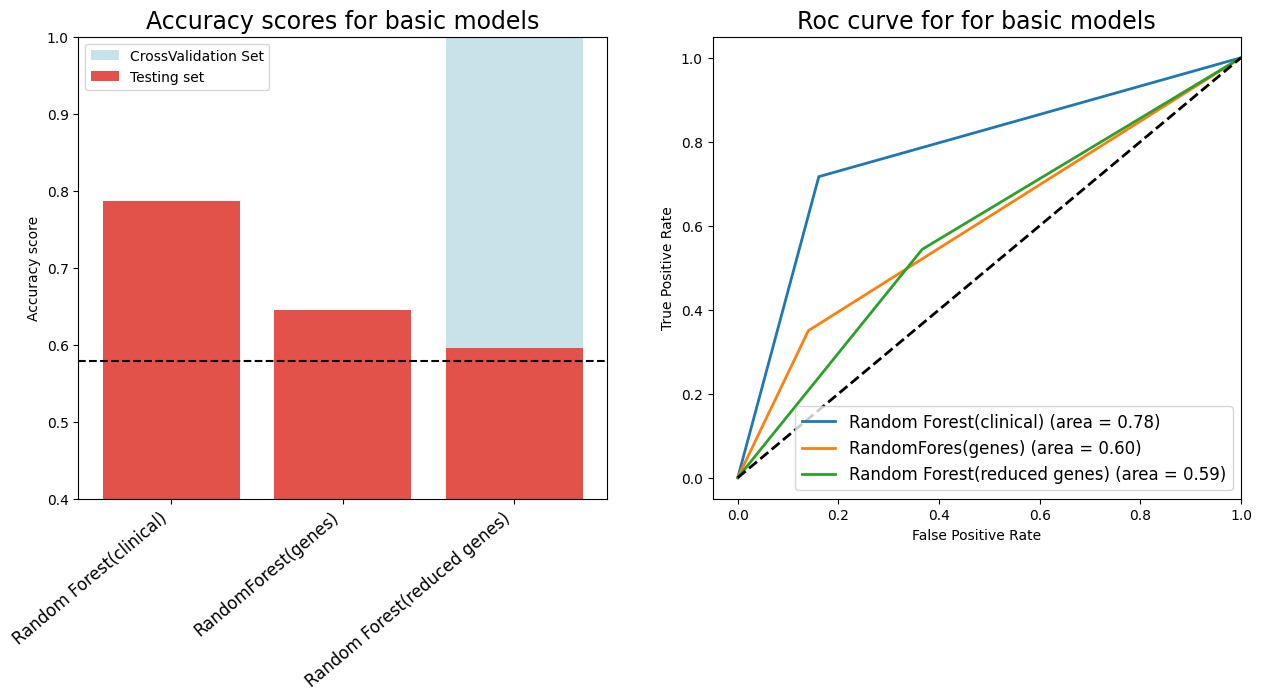

In [181]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

#bar chart of accuracy scores
inds = range(1,4)
labels = ["Random Forest(clinical)","RandomForest(genes)","Random Forest(reduced genes)" ]
scores_all = [clinical_cv_score,gen_cv_score,gen_reduced_cv_score]
scores_predictive = [clinical_test_score,gen_test_score,gen_reduced_test_score]

ax1.bar(inds, scores_all, color=sns.color_palette("Spectral")[5], alpha=0.3, hatch="x", edgecolor="none",label="CrossValidation Set")
ax1.bar(inds, scores_predictive, color=sns.color_palette("Spectral")[0], label="Testing set")
ax1.set_ylim(0.4, 1)
ax1.set_ylabel("Accuracy score")
ax1.axhline(base_line_accuracy[0], color="black", linestyle="--")
ax1.set_title("Accuracy scores for basic models", fontsize=17)
ax1.set_xticks(range(1,4))
ax1.set_xticklabels(labels, size=12, rotation=40, ha="right")
ax1.legend()

labels = ["Random Forest(clinical)","RandomFores(genes)","Random Forest(reduced genes)" ]
for label, pred,y_test in zip(labels, [clinical_test_pred,gen_test_pred,gen_reduced_test_pred],[clinical_y_test,gen_y_test,gen_y_test]):
    fpr, tpr, threshold = roc_curve(y_test.values, pred)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax2.set_xlim([-0.05, 1.0])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc="lower right", prop={'size': 12})
ax2.set_title("Roc curve for for basic models", fontsize=17)

plt.show()